### Evaluating Classification Models
Data:<br>
https://www.kaggle.com/competitions/titanic

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_validate
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
import warnings
sns.set_theme()
randstate=94122

In [2]:
# save selected figures for report
savefig = True
fig_path = 'figs/'
if savefig:
    os.makedirs(fig_path, exist_ok=True) 
    
# export predictions for scoring
save_submission = True
sub_path = 'submissions/'
if save_submission:
    os.makedirs(sub_path, exist_ok=True) 

### Data preparation, exploration, visualization

In [3]:
# overview of data
train = pd.read_csv('train.csv').set_index('PassengerId')
test = pd.read_csv('test.csv').set_index('PassengerId')
submission = pd.read_csv('gender_submission.csv').set_index('PassengerId')
df = pd.concat([train, test], axis=0, sort=False)
print('training data:')
train.info()
print('\ntest data:')
test.info()

training data:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB

test data:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    obj

In [4]:
# confirm that id is unique
df.index.nunique()==len(df)

True

In [5]:
print(f'Train: number of duplicate rows (all duplicates): {train.duplicated(keep=False).sum()}')
print(f'Test: number of duplicate rows (all duplicates): {test.duplicated(keep=False).sum()}')

Train: number of duplicate rows (all duplicates): 0
Test: number of duplicate rows (all duplicates): 0


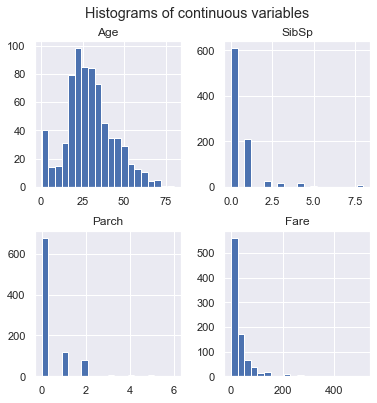

In [74]:
# examine distributions of continuous variables
train[['Age', 'SibSp', 'Parch', 'Fare']].hist(figsize=(6,6), bins=20)
plt.suptitle('Histograms of continuous variables')
plt.subplots_adjust(top=0.9)
if savefig:
    plt.savefig(fig_path+'cont_hist.pdf', format='pdf', bbox_inches='tight')

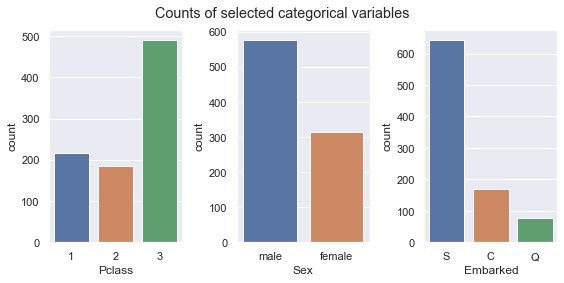

In [7]:
# counts of categorical variables
# most passengers are in class 3; more are male, and most embarked at S
fig, axs = plt.subplots(1,3, figsize=(8,4))
sns.countplot(x='Pclass', data=train, ax=axs[0])
sns.countplot(x='Sex', data=train, ax=axs[1])
sns.countplot(x='Embarked', data=train, ax=axs[2])
fig.tight_layout()
plt.suptitle('Counts of selected categorical variables')
plt.subplots_adjust(top=0.9)
plt.show()
if savefig:
    fig.savefig(fig_path+'cat_count.pdf', format='pdf', bbox_inches='tight')

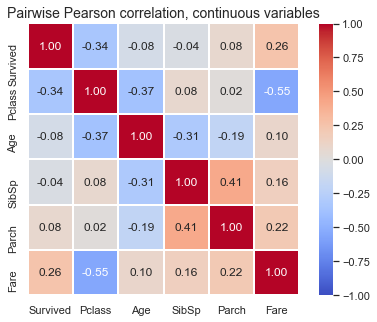

Pclass    Fare      0.549500
SibSp     Parch     0.414838
Pclass    Age       0.369226
Survived  Pclass    0.338481
Age       SibSp     0.308247
Survived  Fare      0.257307
Parch     Fare      0.216225
Age       Parch     0.189119
SibSp     Fare      0.159651
Age       Fare      0.096067
Pclass    SibSp     0.083081
Survived  Parch     0.081629
          Age       0.077221
          SibSp     0.035322
Pclass    Parch     0.018443
dtype: float64

In [8]:
# pairwise pearson correlation of continuous variables
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(train.corr(), cmap='coolwarm', square=True, 
            lw=1, vmin=-1, vmax=1, annot=True, fmt='.2f', ax=ax)
ax.set_title('Pairwise Pearson correlation, continuous variables', fontsize=14)
plt.show()
if savefig:
    fig.savefig(fig_path+'heatmap.pdf', format='pdf', bbox_inches='tight')

# list linear correlation coef
cc = train.corr().abs()
cc_list = cc.where(np.triu(np.ones(cc.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False)
cc_list
# not surprisingly, Pclass is correlated with Fare and inverse correlated with Age; 
# Pclass is correlated with survival

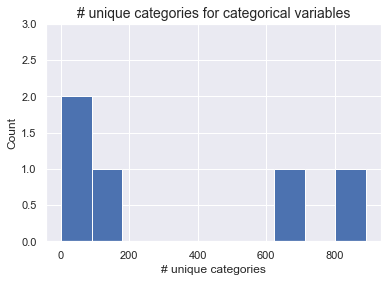

3      1
681    1
2      1
891    1
147    1
Name: unique, dtype: int64


In [9]:
# unique categories for categorical variables
# not including Pclass, which is of numeric type
nunique_cat = train.describe(include=['O']).loc['unique']
fig, ax = plt.subplots()
ax.hist(nunique_cat)
ax.set(xlabel='# unique categories', ylabel='Count')
ax.set_title('# unique categories for categorical variables', fontsize=14)
ax.set_ylim([0, 3])
plt.show()
if savefig:
    fig.savefig(fig_path+'cat_categories.pdf', format='pdf', bbox_inches='tight')
print(nunique_cat.value_counts())

In [10]:
# descriptive stats on training data
print(train.describe())
print('\n', train.describe(include='O'))
# target variable distribution: 38% survived

         Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200

                                  Name   Sex Ticket        Cabin Embarked
count                             891   891    891          204      889
unique                            891     2    681          147        3
top     Boulos, Mrs. Joseph (Sultana)  male   1601  C23 C25 C27        S
freq

In [11]:
# missing values
print('Number of missing values by column, train:')
print(train.isna().sum())
print()
print('Number of missing values by column, test:')
print(test.isna().sum())

Number of missing values by column, train:
Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Number of missing values by column, test:
Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64


In [12]:
# age may depend on pclass and sex
tmp = train.copy()
print(tmp.groupby(['Sex', 'Pclass'])['Age'].median())
print('')
# furthermore, age may depend on title (extracted from name)
tmp['Title'] = tmp['Name'].str.extract('([A-Za-z]+)\.', expand=False)
tmp['Title'] = tmp['Title'].replace('Mlle', 'Miss')
tmp['Title'] = tmp['Title'].replace('Ms', 'Miss')
tmp['Title'] = tmp['Title'].replace('Mme', 'Mrs')
tmp['Title'] = tmp['Title'].replace('Countess', 'Nob')
tmp['Title'] = tmp['Title'].replace('Sir', 'Nob')
tmp['Title'] = tmp['Title'].replace('Lady', 'Nob')
tmp['Title'] = tmp['Title'].apply(lambda x: str(x).replace(x,'Other') if x not in 
          ['Miss', 'Mrs', 'Mr', 'Master', 'Dr', 'Rev', 'Nob'] else str(x))
# the median value of the corresponding [Sex, Pclass, Title] group will be used to impute
tmp.groupby(['Sex', 'Pclass', 'Title'])['Age'].median()

Sex     Pclass
female  1         35.0
        2         28.0
        3         21.5
male    1         40.0
        2         30.0
        3         25.0
Name: Age, dtype: float64



Sex     Pclass  Title 
female  1       Dr        49.0
                Miss      30.0
                Mrs       40.0
                Nob       40.5
        2       Miss      24.0
                Mrs       32.0
        3       Miss      18.0
                Mrs       31.0
male    1       Dr        44.0
                Master     4.0
                Mr        40.0
                Nob       49.0
                Other     52.0
        2       Dr        38.5
                Master     1.0
                Mr        31.0
                Rev       46.5
        3       Master     4.0
                Mr        26.0
Name: Age, dtype: float64

In [13]:
# fare may depend on class and family size
# will impute fare based on the median of the most frequent group (pclass 3, no family members)
train.groupby(['Pclass', 'Parch', 'SibSp'])['Fare'].count().nlargest()

Pclass  Parch  SibSp
3       0      0        324
1       0      0        109
2       0      0        104
1       0      1         51
3       0      1         46
Name: Fare, dtype: int64

In [14]:
# cabin: will create Deck from first character of cabin and then drop cabin
# will combine decks T and C 
train['Cabin'].str[0].value_counts() 

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64

In [15]:
# embarked: will impute with the mode, S
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

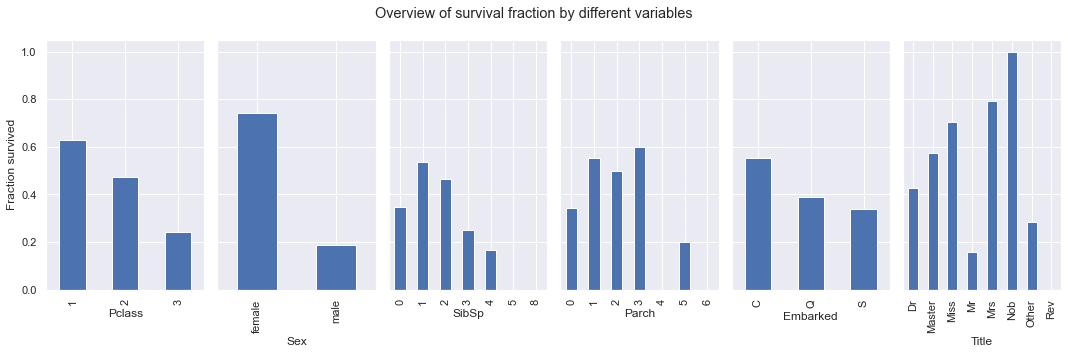

In [16]:
# explore Survived by the selected variables
# Pclass1, female, Embarked-C appears to have higher survival
# Nobility titles (Sir, Lady, etc), women, master, and doctors had good surival chance
# harder to tell with SipSp and Parch, will combine them below
vars_to_explore = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Title']
fig, axs = plt.subplots(1, len(vars_to_explore), figsize=(15,5), sharey=True)
for ii,xx in enumerate(vars_to_explore):
    tmp[[xx, 'Survived']].groupby([xx]).mean().plot(kind='bar',
                                                   xlabel=xx, ylabel='Fraction survived', legend=None, ax=axs[ii])
plt.suptitle('Overview of survival fraction by different variables')
fig.tight_layout()
plt.show()
if savefig:
    fig.savefig(fig_path+'surv_fraction1.pdf', format='pdf', bbox_inches='tight')

In [17]:
# take a closer look at "Master" 
# master is male child below 12 years old
print(tmp[tmp['Title']=='Master']['Sex'].value_counts(), '\n')
print(tmp[tmp['Title']=='Master']['Age'].agg(['min', 'max']))

male    40
Name: Sex, dtype: int64 

min     0.42
max    12.00
Name: Age, dtype: float64


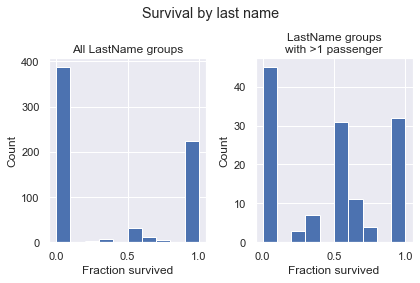

In [18]:
# take a closer look at names, specifically last name
# different last names had different survival probabilities, possibly due to class, deck, and other variables
# last name may also carry additional information such as ethnicity

# get last name from name
tmp['LastName'] = tmp['Name'].str.split(',').str[0]
fig, axs = plt.subplots(1,2)
# get survival for all LastName groups
tmp.groupby('LastName')['Survived'].mean().hist(ax=axs[0])
axs[0].set(ylabel='Count', xlabel='Fraction survived', title='All LastName groups')
# get survival for LastName groups with more than 1 person
tmpg = tmp.groupby('LastName')['Survived'].count()
tmp.groupby('LastName')['Survived'].mean()[tmpg>1].hist(ax=axs[1])
axs[1].set(ylabel='Count', xlabel='Fraction survived', title='LastName groups\nwith >1 passenger')
fig.tight_layout()
plt.suptitle('Survival by last name')
plt.subplots_adjust(top=0.8)
plt.show()
if savefig:
    fig.savefig(fig_path+'lastname.pdf', format='pdf', bbox_inches='tight')

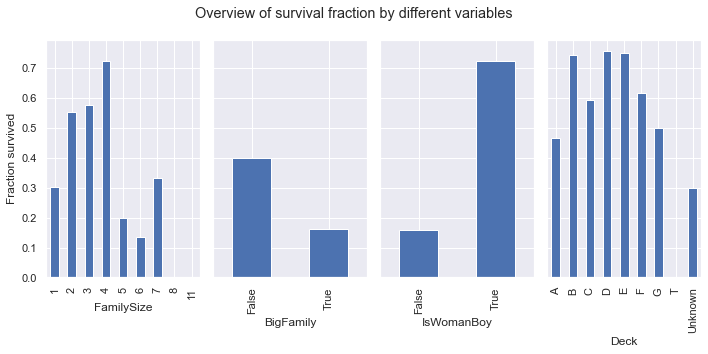

In [19]:
# family sizes of 2-4 had the highest survival, better chances than traveling alone
# BigFamily (parites >4) did not help
# woman and Master/boy had high survival
# deck affects survival rate
tmp['FamilySize'] = tmp['SibSp']+tmp['Parch']+1
tmp['BigFamily'] = tmp['FamilySize']>4
tmp['IsWomanBoy'] = ((tmp['Title']=='Master') | (tmp['Sex']=='female'))
tmp['Deck'] = tmp['Cabin'].str[0].fillna(value='Unknown')
vars_to_explore = ['FamilySize', 'BigFamily', 'IsWomanBoy', 'Deck']
fig, axs = plt.subplots(1, len(vars_to_explore), figsize=(10,5), sharey=True)
for ii,xx in enumerate(vars_to_explore):
    tmp[[xx, 'Survived']].groupby([xx]).mean().plot(kind='bar',
                                                   xlabel=xx, ylabel='Fraction survived', legend=None, ax=axs[ii])
# plt.suptitle('Overview of survival fraction by different variables')
fig.tight_layout()
plt.show()
if savefig:
    fig.savefig(fig_path+'surv_fraction2.pdf', format='pdf', bbox_inches='tight')

Deck layout (source: https://upload.wikimedia.org/wikipedia/commons/5/5d/Titanic_side_plan_annotated_English.png)
![Titanic side plan annotated English](https://upload.wikimedia.org/wikipedia/commons/5/5d/Titanic_side_plan_annotated_English.png)

In [20]:
# females had higher survival by embarked and by Pclass
train.groupby(['Embarked', 'Sex', 'Pclass'])['Survived'].mean()

Embarked  Sex     Pclass
C         female  1         0.976744
                  2         1.000000
                  3         0.652174
          male    1         0.404762
                  2         0.200000
                  3         0.232558
Q         female  1         1.000000
                  2         1.000000
                  3         0.727273
          male    1         0.000000
                  2         0.000000
                  3         0.076923
S         female  1         0.958333
                  2         0.910448
                  3         0.375000
          male    1         0.354430
                  2         0.154639
                  3         0.128302
Name: Survived, dtype: float64

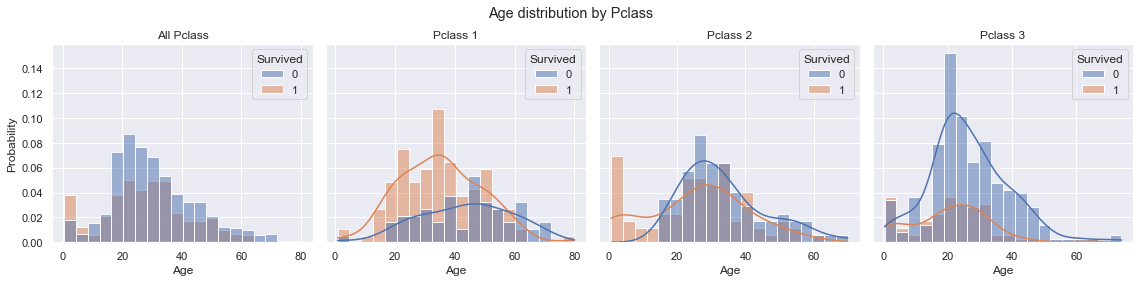

In [21]:
# younger passenger had higher surivial in first class
# overall, mean age for survived was a little lower, perhaps skewed by the children
fig, axs = plt.subplots(1,4, figsize=(16,4), sharey=True)
sns.histplot(x='Age', hue='Survived', data=tmp, stat='probability', bins=20, kde=False, ax=axs[0])
sns.histplot(x='Age', hue='Survived', data=tmp[tmp['Pclass']==1], stat='probability', bins=20, kde=True, ax=axs[1])
sns.histplot(x='Age', hue='Survived', data=tmp[tmp['Pclass']==2], stat='probability', bins=20, kde=True, ax=axs[2])
sns.histplot(x='Age', hue='Survived', data=tmp[tmp['Pclass']==3], stat='probability', bins=20, kde=True, ax=axs[3])
axs[0].set_title('All Pclass')
axs[1].set_title('Pclass 1')
axs[2].set_title('Pclass 2')
axs[3].set_title('Pclass 3')
fig.tight_layout()
plt.suptitle('Age distribution by Pclass')
plt.subplots_adjust(top=0.85)
plt.show()
print(tmp.groupby('Survived')['Age'].describe())
if savefig:
    fig.savefig(fig_path+'age_pclass.pdf', format='pdf', bbox_inches='tight')

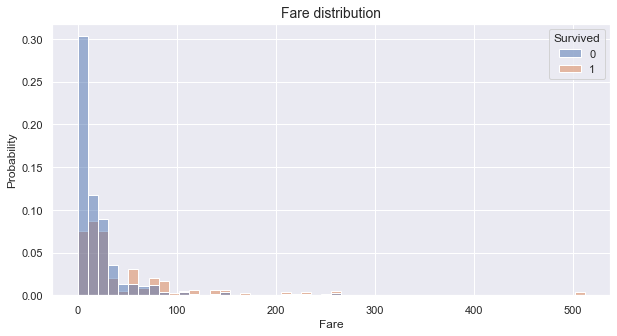


Fare:
          count       mean        std  min      25%   50%   75%       max
Survived                                                                 
0         549.0  22.117887  31.388207  0.0   7.8542  10.5  26.0  263.0000
1         342.0  48.395408  66.596998  0.0  12.4750  26.0  57.0  512.3292

Fare per person (normalized by family size):
          count       mean        std  min     25%     50%   75%       max
Survived                                                                  
0         549.0  13.651162  18.918880  0.0  7.2264   7.925  13.0  227.5250
1         342.0  29.973691  51.116704  0.0  7.7500  13.000  30.5  512.3292


In [22]:
# on average, those who survived paid higher fare.
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(x='Fare', hue='Survived', data=tmp, stat='probability', bins=50, kde=False, ax=ax)
ax.set_title('Fare distribution', fontsize=14)
plt.show()

print('\nFare:')
print(tmp.groupby('Survived')['Fare'].describe())
print('\nFare per person (normalized by family size):')
tmp['FarePerPerson'] = tmp['Fare']/tmp['FamilySize']
print(tmp.groupby('Survived')['FarePerPerson'].describe())
if savefig:
    fig.savefig(fig_path+'fare.pdf', format='pdf', bbox_inches='tight')

#### Feature engineering
Construct transformers that can be used in a feature engineering pipeline

In [23]:
# get Title, LastName from Name
# IsWomanBoy: female or Title is Master (boy)
class ProcessName(BaseEstimator, TransformerMixin):
    def __init__(self):  
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X_ = X.copy() # creating a copy to avoid changes to original dataset
        X_['Title'] = X_['Name'].str.extract('([A-Za-z]+)\.', expand=False)
        X_['Title'] = X_['Title'].replace('Mlle', 'Miss')
        X_['Title'] = X_['Title'].replace('Ms', 'Miss')
        X_['Title'] = X_['Title'].replace('Mme', 'Mrs')
        X_['Title'] = X_['Title'].replace('Countess', 'Nob')
        X_['Title'] = X_['Title'].replace('Sir', 'Nob')
        X_['Title'] = X_['Title'].replace('Lady', 'Nob')
        X_['Title'] = X_['Title'].apply(lambda x: str(x).replace(x,'Other') if x not in 
                  ['Miss', 'Mrs', 'Mr', 'Master', 'Dr', 'Rev', 'Nob'] else str(x))

        X_['IsWomanBoy'] =  ((X_['Title']=='Master') | (X_['Sex']=='female'))
        X_['LastName'] = X_['Name'].str.split(',').str[0]
        return X_

In [24]:
# get metrics related to survival of women and boy in a family (inferred by the same last name
# WomanBoyCount: # of woman/boy in family
# WBSurvCount: # survival count 
# WBSurvRate: # survival rate 
# NoWomanBoy: no woman/boy in family
# FamilySize: SipSp+Parch+self
class Family(BaseEstimator, TransformerMixin):
    def __init__(self):  
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X_ = X.copy() # creating a copy to avoid changes to original dataset
        family = df.groupby(X_['LastName'])['Survived']
        X_['WomanBoyCount'] = family.transform(lambda x: x[X_['IsWomanBoy']].fillna(0).count())
        X_['WomanBoyCount'] = X_.mask(X_['IsWomanBoy'], X_['WomanBoyCount']-1, axis=0)
        X_['WBSurvCount'] = family.transform(lambda x: x[X_['IsWomanBoy']].fillna(0).sum())
        X_['WBSurvCount'] = X_.mask(X_['IsWomanBoy'], X_['WBSurvCount']-X_['Survived'].fillna(0), axis=0)
        X_['WBSurvRate'] = X_['WBSurvCount']/X_['WomanBoyCount'].replace(0, np.nan)
        X_['WomanBoyCount'] = X_['WomanBoyCount'].replace(np.nan, 0)
        X_['NoWomanBoy'] = (X_['WomanBoyCount']==0)
        
        X_['WBSurvRate'] = X_['WBSurvRate'].fillna(0)
        X_['WomanBoyCount'] = X_['WomanBoyCount'].fillna(0)
        X_['WBSurvCount'] = X_['WBSurvCount'].fillna(0)
        X_['NoWomanBoy'] = X_['NoWomanBoy'].fillna(0)
        
        X_['FamilySize'] = X_['SibSp']+X_['Parch']+1
        return X_

In [25]:
# Deck: first char of Cabin
# HasCabin: has Cabin or not (where not = missing value)
class ProcessCabin(BaseEstimator, TransformerMixin):
    def __init__(self):  
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X_ = X.copy() # creating a copy to avoid changes to original dataset
        X_['Deck'] = X_['Cabin'].str[0]
        X_['Deck'] = X_['Deck'].fillna(value='U') # U=unknown
        X_['Deck'] = X_['Deck'].replace('T', 'C') # replace rare entry with most frequent
        X_['HasCabin'] = X_['Deck']!='U' # binary; has cabin or not
        return X_

In [26]:
# impute fare based on median of appropriate group from training data
# group: Pclass and how many family members (SibSp, Parch)
class FareImputer(BaseEstimator, TransformerMixin):
    def __init__(self):  
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X_ = X.copy() # creating a copy to avoid changes to original dataset
        group_mode = train.groupby(['Pclass', 'Parch', 'SibSp'])['Fare'].count().idxmax()
        fare_med = X_.groupby(['Pclass', 'Parch', 'SibSp'])['Fare'].median()[group_mode]   
        X_['Fare'] = X_['Fare'].fillna(fare_med)
        return X_

In [27]:
# impute age based on median appropriate group
# group: Sex, Pclass, Title
class AgeImputer(BaseEstimator, TransformerMixin):
    def __init__(self):  
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X_ = X.copy() # creating a copy to avoid changes to original dataset    
        X_['Age'] = X_.groupby(['Sex', 'Pclass', 'Title'])['Age'].apply(lambda x: x.fillna(x.median()))
        return X_

In [28]:
# impute Embarked values with most frequent
class EmbarkedImputer(BaseEstimator, TransformerMixin):
    def __init__(self):  
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X_ = X.copy() # creating a copy to avoid changes to original dataset    
        X_['Embarked'].fillna(train['Embarked'].value_counts().index[0], inplace=True)
        return X_

In [29]:
# bin age using 15-year bins
class AgeBinned(BaseEstimator, TransformerMixin):
    def __init__(self):  
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X_ = X.copy() # creating a copy to avoid changes to original dataset    
        X_['AgeBinned'] = pd.cut(X_['Age'], [0, 15, 30, 45, 60, np.inf], labels=range(5), include_lowest=True)
        return X_

In [30]:
# for dropping columns 
class DropCol(BaseEstimator, TransformerMixin):
    def __init__(self, feature_name):  
        self.feature_name = feature_name
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X_ = X.copy() # creating a copy to avoid changes to original dataset
        X_.drop(self.feature_name, axis=1, inplace=True)
        return X_

Construct and apply feature engineering pipeline

In [31]:
# feature engineering pipeline, logistic regression
pipe_feateng_lr = make_pipeline(ProcessName(), Family(), ProcessCabin(),
                                FareImputer(), AgeImputer(), AgeBinned(),
                                DropCol('Name'), DropCol('Ticket'), DropCol('Cabin'), EmbarkedImputer(),
                               )

In [32]:
# apply feature engineering pipeline
df_feateng_lr = pipe_feateng_lr.fit_transform(df)
df_feateng_lr.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,IsWomanBoy,LastName,WomanBoyCount,WBSurvCount,WBSurvRate,NoWomanBoy,FamilySize,Deck,HasCabin,AgeBinned
PassengerId,,,,,,,,,,,,,,,,,,,
1,0.0,3,male,22.0,1,0,7.2500,S,Mr,False,Braund,0.0,0.0,0.0,True,2,U,False,1
2,1.0,1,female,38.0,1,0,71.2833,C,Mrs,True,Cumings,0.0,0.0,0.0,True,2,C,True,2
3,1.0,3,female,26.0,0,0,7.9250,S,Miss,True,Heikkinen,0.0,0.0,0.0,True,1,U,False,1
4,1.0,1,female,35.0,1,0,53.1000,S,Mrs,True,Futrelle,0.0,0.0,0.0,True,2,C,True,2
5,0.0,3,male,35.0,0,0,8.0500,S,Mr,False,Allen,0.0,0.0,0.0,True,1,U,False,2


Binary features include: <br>Sex, IsWomanBoy (is woman or boy), NoWomanBoy (no woman or boy in group by last name), HasCabin (has character in cabin or not)

#### Preprocessing 
Encoding and scaling

In [33]:
# train and test set after feature engineering
X_train_lr = df_feateng_lr.drop('Survived', axis=1).loc[train.index]
X_test_lr = df_feateng_lr.drop('Survived', axis=1).loc[test.index]
# target variable
y_train = df_feateng_lr['Survived'].loc[train.index]
print('train:', X_train_lr.shape, y_train.shape)
print('test:', X_test_lr.shape)

train: (891, 18) (891,)
test: (418, 18)


In [34]:
# define columns for preprocessing
num_cols = X_train_lr.select_dtypes(include=np.number).columns.tolist()
num_cols = [xx for xx in num_cols if xx not in ['Pclass']]
print(f'{len(num_cols)} numeric variables:', num_cols)

cat_cols = [xx for xx in X_train_lr.columns if xx not in num_cols and xx not in ['LastName']]
print(f'{len(cat_cols)} categorical variables:', cat_cols)

lastnames = df_feateng_lr['LastName'].unique().tolist() # list of LastName for encoding

8 numeric variables: ['Age', 'SibSp', 'Parch', 'Fare', 'WomanBoyCount', 'WBSurvCount', 'WBSurvRate', 'FamilySize']
9 categorical variables: ['Pclass', 'Sex', 'Embarked', 'Title', 'IsWomanBoy', 'NoWomanBoy', 'Deck', 'HasCabin', 'AgeBinned']


In [35]:
# define scalers and encoders
# standardization
pipe_std = make_pipeline(StandardScaler())
# one-hot
pipe_onehot = make_pipeline(OneHotEncoder(sparse=False, handle_unknown='ignore',
                                                drop=None))
# ordinal 
pipe_ord = make_pipeline(OrdinalEncoder())
pipe_ord2 = make_pipeline(OrdinalEncoder(categories=[lastnames]))

Construct and apply preprocessing pipeline

In [36]:
# preprocessor
pipe_preproc_lr = ColumnTransformer(transformers=[
    ('stdscaler', pipe_std, num_cols),
#     ('onehot', pipe_onehotencoder, onehot_cols),
    ('ord', pipe_ord, cat_cols),
    ('ord2', pipe_ord2, ['LastName'])
], remainder='passthrough')

In [37]:
# workaround function for getting feature names from all transformers
# useful for transformers that do not provide a get_feature_names() method
# source: 
# https://johaupt.github.io/scikit-learn/tutorial/python/data%20processing/
# ml%20pipeline/model%20interpretation/columnTransformer_feature_names.html

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [38]:
# verify preprocessing pipeline
train_preproc_lr = pd.DataFrame(pipe_preproc_lr.fit_transform(X_train_lr),
                                index=X_train_lr.index,
                                columns=get_feature_names(pipe_preproc_lr))

# get original feature names from onehotencoder
# onehotmap = dict(zip(['onehotencoder__'+xx for xx in
#                       pipe_preproc_lr.transformers_[1][1]['onehotencoder'].get_feature_names().tolist()],
#                      ['onehotencoder__'+xx for xx in
#                       pipe_preproc_lr.transformers_[1][1]['onehotencoder'].get_feature_names(onehot_cols).tolist()]))

# examine preprocessed 
# train_preproc_lr.rename(columns=onehotmap, inplace=True)
train_preproc_lr

/Users/lawrencehuang/opt/anaconda3/envs/msds422/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Transformer standardscaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
/Users/lawrencehuang/opt/anaconda3/envs/msds422/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Transformer ordinalencoder (type OrdinalEncoder) does not provide get_feature_names. Will return input column names if available


,stdscaler__Age,stdscaler__SibSp,stdscaler__Parch,stdscaler__Fare,stdscaler__WomanBoyCount,stdscaler__WBSurvCount,stdscaler__WBSurvRate,stdscaler__FamilySize,ord__Pclass,ord__Sex,ord__Embarked,ord__Title,ord__IsWomanBoy,ord__NoWomanBoy,ord__Deck,ord__HasCabin,ord__AgeBinned,ord2__LastName
PassengerId,,,,,,,,,,,,,,,,,,
1,-0.531848,0.432793,-0.473674,-0.502445,-0.472813,-0.454687,-0.471808,0.059160,2.0,1.0,2.0,3.0,0.0,1.0,7.0,0.0,1.0,0.0
2,0.649674,0.432793,-0.473674,0.786845,-0.472813,-0.454687,-0.471808,0.059160,0.0,0.0,0.0,4.0,1.0,1.0,2.0,1.0,2.0,1.0
3,-0.236468,-0.474545,-0.473674,-0.488854,-0.472813,-0.454687,-0.471808,-0.560975,2.0,0.0,2.0,2.0,1.0,1.0,7.0,0.0,1.0,2.0
4,0.428139,0.432793,-0.473674,0.420730,-0.472813,-0.454687,-0.471808,0.059160,0.0,0.0,2.0,4.0,1.0,1.0,2.0,1.0,2.0,3.0
5,0.428139,-0.474545,-0.473674,-0.486337,-0.472813,-0.454687,-0.471808,-0.560975,2.0,1.0,2.0,3.0,0.0,1.0,7.0,0.0,2.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,-0.162623,-0.474545,-0.473674,-0.386671,-0.472813,-0.454687,-0.471808,-0.560975,1.0,1.0,2.0,7.0,0.0,1.0,7.0,0.0,1.0,664.0
888,-0.753384,-0.474545,-0.473674,-0.044381,0.358107,1.511946,2.290999,-0.560975,0.0,0.0,2.0,2.0,1.0,0.0,1.0,1.0,1.0,233.0
889,-0.827229,0.432793,2.008933,-0.176263,1.189026,-0.454687,-0.471808,1.299429,2.0,0.0,2.0,2.0,1.0,0.0,7.0,0.0,1.0,604.0


### Modeling: logistic regression
Construct pipeline with preprocessing and modeling

In [39]:
# model pipeline
# with built-in parameter tuning for LogisticRegression
# use L1 penalty for feature selection
pipe_model_lr = Pipeline(steps=[
    ('preprocess', pipe_preproc_lr),
    ('algo', LogisticRegressionCV(max_iter=10000, cv=5, Cs=100, scoring='accuracy', 
                                  penalty='l1', solver='liblinear', n_jobs=-1, random_state=randstate)),
])

# cross-validation
cv_scores = cross_validate(pipe_model_lr, X_train_lr, y_train,
                           scoring=['roc_auc', 'accuracy'], 
                           cv=5, verbose=1, n_jobs=-1)

# mean metrics
print('mean val roc_auc = {:.4f}'.format(cv_scores['test_roc_auc'].mean()))
print('mean val accuracy = {:.4f}'.format(cv_scores['test_accuracy'].mean()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.1s remaining:    4.6s


mean val roc_auc = 0.9832
mean val accuracy = 0.9249


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished


In [40]:
# train model on all training data and predict
pipe_model_lr.fit(X_train_lr, y_train)
y_pred = pipe_model_lr.predict(X_test_lr).astype(int)
submission_lr = submission.copy()
submission_lr['Survived'] = y_pred
if save_submission:
    submission_lr.to_csv(sub_path+'submission_lr.csv')
submission_lr.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


### Review results, evaluate model

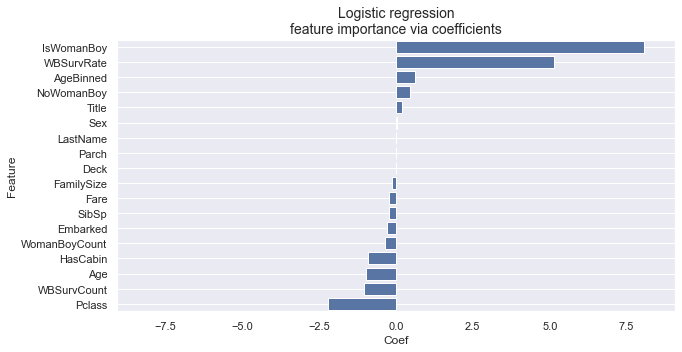

Features with zero coefficient: ['Parch']


In [67]:
# feature importance via coefficients
coef_df = pd.DataFrame({'Feature':train_preproc_lr.columns, 'Coef':pipe_model_lr['algo'].coef_[0]})
coef_df['Feature'] = coef_df['Feature'].apply(lambda x: x.split('__')[1])
coef_df.sort_values('Coef', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Coef', y='Feature', data=coef_df, color='#4C72B0', ax=ax)
maxval = coef_df['Coef'].abs().max()+1
ax.set_xlim([-maxval, maxval])
ax.set_title('Logistic regression\nfeature importance via coefficients', fontsize=14)
ax.grid()
plt.show()
if savefig:
    fig.savefig(fig_path+'feat_importance_lr.pdf', format='pdf', bbox_inches='tight')

print('Features with zero coefficient:', coef_df.loc[coef_df['Coef']==0, 'Feature'].tolist())

In [42]:
# best model param
# C = inverse of regularization strength (smaller values specify stronger regularization)
pipe_model_lr['algo'].C_

array([10.23531022])

### Modeling: Naïve Bayes
BernoulliNB is designed for binary/boolean features and suitable for discrete data
<br>GaussianNB follows the Gaussian normal distribution and may be better for the continuous features

Try BernoulliNB and GaussianNB

In [43]:
# model pipeline
pipe_model_nb = Pipeline(steps=[
    ('preprocess', pipe_preproc_lr),
    ('algo', GaussianNB()),
])

# cross-validation
cv_scores = cross_validate(pipe_model_nb, X_train_lr, y_train,
                           scoring=['roc_auc', 'accuracy'], 
                           cv=5, verbose=1, n_jobs=-1)

# mean metrics
print('mean val roc_auc = {:.4f}'.format(cv_scores['test_roc_auc'].mean()))
print('mean val accuracy = {:.4f}'.format(cv_scores['test_accuracy'].mean()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s


mean val roc_auc = 0.9474
mean val accuracy = 0.8485


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


In [44]:
# train model on all training data and predict
pipe_model_nb.fit(X_train_lr, y_train)
y_pred = pipe_model_nb.predict(X_test_lr).astype(int)
submission_nb = submission.copy()
submission_nb['Survived'] = y_pred
if save_submission:
    submission_nb.to_csv(sub_path+'submission_gnb0.csv')
submission_nb.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [45]:
# model pipeline
pipe_model_nb = Pipeline(steps=[
    ('preprocess', pipe_preproc_lr),
    ('algo', BernoulliNB()),
])

# cross-validation
cv_scores = cross_validate(pipe_model_nb, X_train_lr, y_train,
                           scoring=['roc_auc', 'accuracy'], 
                           cv=5, verbose=1, n_jobs=-1)

# mean metrics
print('mean val roc_auc = {:.4f}'.format(cv_scores['test_roc_auc'].mean()))
print('mean val accuracy = {:.4f}'.format(cv_scores['test_accuracy'].mean()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s


mean val roc_auc = 0.9249
mean val accuracy = 0.8373


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


In [46]:
# train model on all training data and predict
pipe_model_nb.fit(X_train_lr, y_train)
y_pred = pipe_model_nb.predict(X_test_lr).astype(int)
submission_nb = submission.copy()
submission_nb['Survived'] = y_pred
if save_submission:
    submission_nb.to_csv(sub_path+'submission_bnb0.csv')
submission_nb.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


Cross-validated roc_auc and accuracy were lower than for logistic regression (scores on test set were also lower)<br>
Strategy: focus on BernoulliNB; test some additional features; and use a wrapper method for feature selection<br>
Use one-hot encoder to return binary features

#### Feature engineering revisited
Construct additional transformers that can be used in a feature engineering pipeline

In [47]:
# BigFamily: family size > 4?
# NoSibSpParch: family size = 1?
# FarePerPerson: fare normalized by family size
class BigFamily(BaseEstimator, TransformerMixin):
    def __init__(self):  
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X_ = X.copy() # creating a copy to avoid changes to original dataset
        X_['BigFamily'] =  X_['FamilySize']>4
        X_['NoSibSpParch'] = X_['FamilySize']==1 
        X_['FarePerPerson'] = X_['Fare']/X_['FamilySize']
        return X_

In [48]:
# TicketChar: the leading character of ticket, if any
# TicketHasChar: does ticket contain any char?
class TicketChar(BaseEstimator, TransformerMixin):
    def __init__(self):  
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X_ = X.copy() # creating a copy to avoid changes to original dataset
        X_['TicketChar'] = X_['Ticket'].str.split(" ").str.get(0).str.get(0)\
        .apply(lambda x: str(x).replace(x,'N') if x.isdigit() else str(x))        
        X_['TicketHasChar'] = ~X_['Ticket'].str.isdigit()
        return X_

In [49]:
# Bin fare based on percentiles
class FareBinned(BaseEstimator, TransformerMixin):
    def __init__(self):  
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X_ = X.copy() # creating a copy to avoid changes to original dataset
        farebins = train['Fare'].quantile([0, 0.25, 0.5, 0.75, 0.9, 0.99]).to_numpy()
        farebins = np.concatenate((farebins, [np.inf]))       
        X_['FareBin'] = pd.cut(X_['Fare'], bins=farebins, 
                                       labels=range(len(farebins)-1), include_lowest=True)
        return X_

In [50]:
# combine Age and Pclass
class AgexPclass(BaseEstimator, TransformerMixin):
    def __init__(self):  
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X_ = X.copy() # creating a copy to avoid changes to original dataset
        X_['AgexPclass'] =  X_['Age']*X_['Pclass']
        return X_

Construct and apply feature engineering pipeline

In [51]:
# feature engineering pipeline, naive bayes
pipe_feateng_nb = make_pipeline(ProcessName(), Family(), ProcessCabin(),
                                FareImputer(), AgeImputer(), TicketChar(),
                                DropCol('Name'), DropCol('Ticket'), DropCol('Cabin'), EmbarkedImputer(),
                                AgeBinned(), FareBinned(), BigFamily(),
                                DropCol('WomanBoyCount'), DropCol('WBSurvRate'), DropCol('WBSurvCount'), 
                                AgexPclass(), DropCol('NoWomanBoy')
                               )

In [52]:
# apply feature engineering pipeline
df_feateng_nb = pipe_feateng_nb.fit_transform(df)
df_feateng_nb.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,IsWomanBoy,...,Deck,HasCabin,TicketChar,TicketHasChar,AgeBinned,FareBin,BigFamily,NoSibSpParch,FarePerPerson,AgexPclass
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3,male,22.0,1,0,7.2500,S,Mr,False,...,U,False,A,True,1,0,False,False,3.62500,66.0
2,1.0,1,female,38.0,1,0,71.2833,C,Mrs,True,...,C,True,P,True,2,3,False,False,35.64165,38.0
3,1.0,3,female,26.0,0,0,7.9250,S,Miss,True,...,U,False,S,True,1,1,False,True,7.92500,78.0
4,1.0,1,female,35.0,1,0,53.1000,S,Mrs,True,...,C,True,N,False,2,3,False,False,26.55000,35.0
5,0.0,3,male,35.0,0,0,8.0500,S,Mr,False,...,U,False,N,False,2,1,False,True,8.05000,105.0


Binary features include: <br>Sex, IsWomanBoy (is woman or boy), HasCabin (has character in cabin or not), <br>TicketHasChar (ticket was not all numeric), BigFamily (or not), NoSibSpParch (No spouse, siblings, parents, children)
<br> Other categorical features will be one-hot encoded as binary

#### Preprocessing
Encoding and scaling

In [53]:
# train and test set after feature engineering
X_train_nb = df_feateng_nb.drop('Survived', axis=1).loc[train.index]
X_test_nb = df_feateng_nb.drop('Survived', axis=1).loc[test.index]
# target variable
y_train = df_feateng_nb['Survived'].loc[train.index]
print('train:', X_train_nb.shape, y_train.shape)
print('test:', X_test_nb.shape)

train: (891, 21) (891,)
test: (418, 21)


In [54]:
# define columns for preprocessing
num_cols = df_feateng_nb.select_dtypes(include=np.number).columns.tolist()
num_cols = [xx for xx in num_cols if xx not in ['Survived', 'Pclass']]
print(f'{len(num_cols)} numeric variables:', num_cols)

onehot_cols = [xx for xx in df_feateng_nb.columns if xx not in num_cols and xx not in ['Survived']]
print(f'{len(onehot_cols)} categorical variables:', onehot_cols)

7 numeric variables: ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'FarePerPerson', 'AgexPclass']
14 categorical variables: ['Pclass', 'Sex', 'Embarked', 'Title', 'IsWomanBoy', 'LastName', 'Deck', 'HasCabin', 'TicketChar', 'TicketHasChar', 'AgeBinned', 'FareBin', 'BigFamily', 'NoSibSpParch']


Construct and apply preprocessing pipeline

In [55]:
# preprocessor
pipe_preproc_nb = ColumnTransformer(transformers=[
    ('stdscaler', pipe_std, num_cols),
    ('onehot', pipe_onehot, onehot_cols),
], remainder='passthrough')

In [56]:
# verify preprocessing pipeline
train_preproc_nb = pd.DataFrame(pipe_preproc_nb.fit_transform(X_train_nb),
                                index=X_train_nb.index,
                                columns=get_feature_names(pipe_preproc_nb))

# get original feature names from onehotencoder
onehotmap = dict(zip(['onehotencoder__'+xx for xx in
                      pipe_preproc_nb.transformers_[1][1]['onehotencoder'].get_feature_names().tolist()],
                     ['onehotencoder__'+xx for xx in
                      pipe_preproc_nb.transformers_[1][1]['onehotencoder'].get_feature_names(onehot_cols).tolist()]))

# examine preprocessed 
train_preproc_nb.rename(columns=onehotmap, inplace=True)
train_preproc_nb

/Users/lawrencehuang/opt/anaconda3/envs/msds422/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Transformer standardscaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available


,stdscaler__Age,stdscaler__SibSp,stdscaler__Parch,stdscaler__Fare,stdscaler__FamilySize,stdscaler__FarePerPerson,stdscaler__AgexPclass,onehotencoder__Pclass_1,onehotencoder__Pclass_2,onehotencoder__Pclass_3,...,onehotencoder__FareBin_0,onehotencoder__FareBin_1,onehotencoder__FareBin_2,onehotencoder__FareBin_3,onehotencoder__FareBin_4,onehotencoder__FareBin_5,onehotencoder__BigFamily_False,onehotencoder__BigFamily_True,onehotencoder__NoSibSpParch_False,onehotencoder__NoSibSpParch_True
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,-0.531848,0.432793,-0.473674,-0.502445,0.059160,-0.454798,0.105564,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.649674,0.432793,-0.473674,0.786845,0.059160,0.438994,-0.776968,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,-0.236468,-0.474545,-0.473674,-0.488854,-0.560975,-0.334757,0.483792,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.428139,0.432793,-0.473674,0.420730,0.059160,0.185187,-0.871525,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
5,0.428139,-0.474545,-0.473674,-0.486337,-0.560975,-0.331267,1.334806,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,-0.162623,-0.474545,-0.473674,-0.386671,-0.560975,-0.193081,-0.272664,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
888,-0.753384,-0.474545,-0.473674,-0.044381,-0.560975,0.281499,-1.375829,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
889,-0.827229,0.432793,2.008933,-0.176263,1.299429,-0.392335,-0.272664,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


Construct pipeline with preprocessing and modeling

In [57]:
# modeling pipeline 
# with grid search for BernoulliNB

# param_grid 
param_grid = {'alpha':np.logspace(-4,4,100)}

pipe_model_nb = Pipeline(steps=[
    ('preprocessor', pipe_preproc_nb),
    ('algo', GridSearchCV(estimator=BernoulliNB(), param_grid=param_grid, cv=3,
                         scoring='accuracy', n_jobs=-1, verbose=1))
])

# cross-validation
cv_scores = cross_validate(pipe_model_nb, X_train_nb, y_train,
                           scoring=['roc_auc', 'accuracy'], 
                           cv=3, verbose=1, n_jobs=-1)

# mean metrics
print('mean val roc_auc = {:.4f}'.format(cv_scores['test_roc_auc'].mean()))
print('mean val accuracy = {:.4f}'.format(cv_scores['test_accuracy'].mean()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


mean val roc_auc = 0.8588
mean val accuracy = 0.8002


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished


In [58]:
# feature selection by forward SequentialFeatureSelector
# see if fewer features could be used to achieve comparable cv scores
# param_grid for naive bayes
param_grid = {'alpha':np.logspace(-4,4,100)}

for f2sel in [10, 20, 40, 80]: # features to select
    
    # update modeling pipeline
    # feature selection by forward SequentialFeatureSelector
    # grid search for BernoulliNB param
    pipe_model_nb = Pipeline(steps=[
    ('preprocessor', pipe_preproc_nb),
    ('sfs',SequentialFeatureSelector(BernoulliNB(),
                                     n_features_to_select=f2sel, cv=3,
                                     direction='forward', scoring='accuracy', n_jobs=-1)),
    ('algo', GridSearchCV(estimator=BernoulliNB(), param_grid=param_grid, cv=3,
                         scoring='accuracy', n_jobs=-1, verbose=1))
    ])
    
    # cross-validation
    cv_scores = cross_validate(pipe_model_nb, X_train_nb, y_train,
                               scoring=['roc_auc', 'accuracy'], 
                               cv=3, verbose=1, n_jobs=-1)

    # mean metrics
    print('features selected: {}'.format(pipe_model_nb['sfs'].n_features_to_select))
    print('mean val roc_auc = {:.4f}'.format(cv_scores['test_roc_auc'].mean()))
    print('mean val accuracy = {:.4f}'.format(cv_scores['test_accuracy'].mean()))
    print('*'*50)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


features selected: 10
mean val roc_auc = 0.8516
mean val accuracy = 0.8283
**************************************************


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 10.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


features selected: 20
mean val roc_auc = 0.8520
mean val accuracy = 0.8272
**************************************************


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 19.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


features selected: 40
mean val roc_auc = 0.8543
mean val accuracy = 0.8305
**************************************************


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 38.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


features selected: 80
mean val roc_auc = 0.8533
mean val accuracy = 0.8361
**************************************************


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 74.1min finished


In [59]:
# train model on all training data and predict
# choose 40 features as it returned the best cv roc_auc (and relatively high accuracy)
for f2sel in [40]: # features to select
    
    pipe_model_nb = Pipeline(steps=[
    ('preprocessor', pipe_preproc_nb),
    ('sfs',SequentialFeatureSelector(BernoulliNB(),
                                     n_features_to_select=f2sel, cv=3,
                                     direction='forward', scoring='accuracy', n_jobs=-1)),
    ('algo', GridSearchCV(estimator=BernoulliNB(), param_grid=param_grid, cv=3,
                         scoring='accuracy', n_jobs=-1, verbose=1))
    ])
    
    pipe_model_nb.fit(X_train_nb, y_train)
    y_pred = pipe_model_nb.predict(X_test_nb).astype(int)
    submission_nb = submission.copy()
    submission_nb['Survived'] = y_pred
    if save_submission:
        submission_nb.to_csv(sub_path+'submission_bnb_'+str(f2sel)+'.csv')

Fitting 3 folds for each of 100 candidates, totalling 300 fits


### Review results, evaluate model

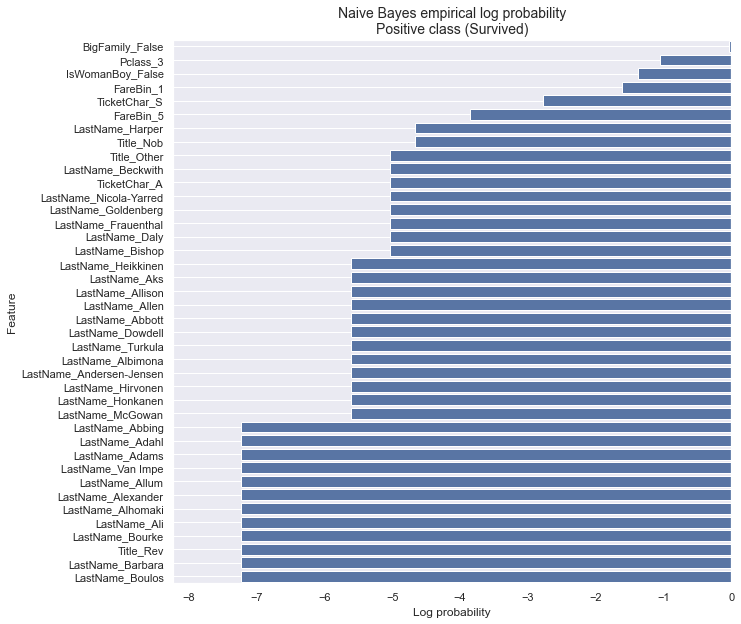

In [66]:
# feature importance via log probability
coef_df = pd.DataFrame({'Feature':train_preproc_nb.columns[pipe_model_nb['sfs'].get_support()],
                        'Log probability':pipe_model_nb['algo'].best_estimator_.feature_log_prob_[1,:]})
coef_df['Feature'] = coef_df['Feature'].apply(lambda x: x.split('__')[1])
coef_df.sort_values('Log probability', ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x='Log probability', y='Feature', data=coef_df, color='#4C72B0', ax=ax)
maxval = coef_df['Log probability'].abs().max()+1
ax.set_xlim([-maxval, None])
ax.set_title('Naive Bayes empirical log probability\nPositive class (Survived)', fontsize=14)
ax.grid()
plt.show()
if savefig:
    fig.savefig(fig_path+'feat_importance_nb.pdf', format='pdf', bbox_inches='tight')

In [61]:
# best model param from gridsearch
pipe_model_nb['algo'].best_params_

{'alpha': 0.24770763559917114}

### Compare with another model (random forest)

In [62]:
# try RandomForestClassifier using 
# feature engineering and preprocessing from logistic regression

# param grid for random forest
param_grid = { 
    'criterion':['gini', 'entropy'],
    'n_estimators':[100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10, 12, 14, None],
}

# modeling pipeline
pipe_model_rf = Pipeline(steps=[
    ('preprocessor', pipe_preproc_lr),
    ('algo', GridSearchCV(estimator=RandomForestClassifier(random_state=randstate),
                          param_grid=param_grid, cv=3,
                          scoring='accuracy', n_jobs=-1, verbose=1))
    ])

cv_scores = cross_validate(pipe_model_rf, X_train_lr, y_train,
                           scoring=['roc_auc', 'accuracy'], 
                           cv=3, verbose=1, n_jobs=-1)

# mean metrics
print('mean val roc_auc = {:.4f}'.format(cv_scores['test_roc_auc'].mean()))
print('mean val accuracy = {:.4f}'.format(cv_scores['test_accuracy'].mean()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


mean val roc_auc = 0.9850
mean val accuracy = 0.9327


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.9min finished


In [63]:
# train model on all training data and predict
pipe_model_rf.fit(X_train_lr, y_train)
y_pred = pipe_model_rf.predict(X_test_lr).astype(int)
submission_rf = submission.copy()
submission_rf['Survived'] = y_pred
if save_submission:
    submission_rf.to_csv(sub_path+'submission_rf.csv')
submission_rf.head()

Fitting 3 folds for each of 72 candidates, totalling 216 fits


,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


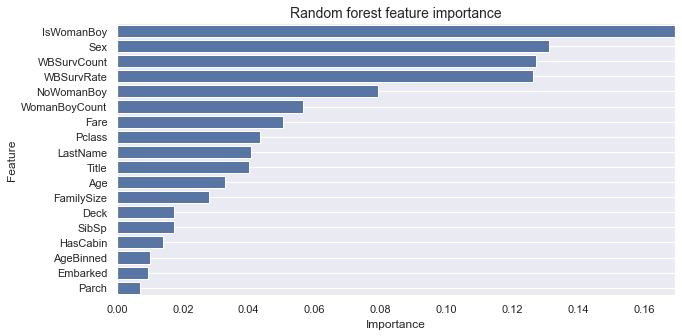

In [64]:
# feature importance via coefficients
coef_df = pd.DataFrame({'Feature':train_preproc_lr.columns,
                        'Importance':pipe_model_rf['algo'].best_estimator_.feature_importances_})
coef_df['Feature'] = coef_df['Feature'].apply(lambda x: x.split('__')[1])
coef_df.sort_values('Importance', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Importance', y='Feature', data=coef_df, color='#4C72B0', ax=ax)
maxval = coef_df['Importance'].abs().max()
ax.set_xlim([None, maxval])
ax.set_title('Random forest feature importance', fontsize=14)
ax.grid()
plt.show()
if savefig:
    fig.savefig(fig_path+'feat_importance_rf.pdf', format='pdf')

In [65]:
# best model param from gridsearch
pipe_model_rf['algo'].best_params_

{'criterion': 'gini',
 'max_depth': 12,
 'max_features': 'auto',
 'n_estimators': 100}